<a href="https://colab.research.google.com/github/allispaul/audiobot/blob/main/models/GTZAN_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#The Erd&#337;s Institute Fall Boot Camp - Team Audiobots


We are going to use transfer learning on Inception/ResNet, and a CNN from scratch to predict music genre.
The below code is modified from a project I did to fine-tune VGG-16 on a new set of classes.


In [3]:
# imports
#from keras.applications.inception_v3 import InceptionV3 #God I love Keras sometimes
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.imagenet_utils import preprocess_input
from keras.optimizers import SGD

# need the new one for the confusion matrix
!pip install scikit-learn==0.22

# mount google drive
from google.colab import drive
drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 24.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for scikit-learn
  Running setup.py clean for scikit-learn
Failed to build scikit-learn
ERROR: Could not build wheels for scikit-learn, which is required to install pyproject.toml-based projects
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Part 1: Data Analysis - if rerunning, run from here Ctrl+F10

*   How many training images?
*   How many testing images?



In [24]:
import os
import numpy as np
EPOCHS = 32 # up from 20 # Training will automatically stop when val loss increases
BATCH_SIZE = 32 # may increase this, for better gradient

TRAIN_DIR = '/content/drive/MyDrive/Colab Notebooks/Erdos Institute Boot Camp/Audiobots/Data/GTZAN/log/train'
TEST_DIR = '/content/drive/MyDrive/Colab Notebooks/Erdos Institute Boot Camp/Audiobots/Data/GTZAN/log/test'

# Sanity check
target_names = [item for item in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR, item))]
nb_train_samples = sum([len(files) for _, _, files in os.walk(TRAIN_DIR)])
nb_test_samples = sum([len(files) for _, _, files in os.walk(TEST_DIR)])
total_nb_samples = nb_train_samples + nb_test_samples

nb_classes = len(target_names)      # number of output classes

print('Training a CNN Multi-Classifier Model ......')
print('\n - names of classes: ', target_names, '\n - # of classes: ', nb_classes)
print(' - # of training samples: ', nb_train_samples, '\n - split into  ', 0.2*nb_train_samples, ' validation samples'
      '\n - # of test samples: ', nb_test_samples,
       '\n - total # of samples: ', total_nb_samples, '\n - train ratio:', round(nb_train_samples/total_nb_samples*100, 2),
     ' %', '\n - # of epochs: ', EPOCHS, '\n - batch size: ', BATCH_SIZE)

#train on the entire set every epoch
STEPS_PER_EPOCH = 23#nb_train_samples//BATCH_SIZE #number of batches per epoch
VALIDATION_STEPS = 0.2*nb_train_samples//BATCH_SIZE

print("Steps per epoch: ", STEPS_PER_EPOCH)
print("Validation steps: ", VALIDATION_STEPS)

Training a CNN Multi-Classifier Model ......

 - names of classes:  ['country', 'metal', 'reggae', 'classical', 'disco', 'jazz', 'rock', 'hiphop', 'pop', 'blues'] 
 - # of classes:  10
 - # of training samples:  899 
 - split into   179.8  validation samples
 - # of test samples:  100 
 - total # of samples:  999 
 - train ratio: 89.99  % 
 - # of epochs:  32 
 - batch size:  32
Steps per epoch:  23
Validation steps:  5.0


#Part 2: Creating the Model

Import the VGG16 model. Inception tries to classify images into 1000 different categories. We only have 16. So we're going to remove the last layer, freeze the model, and add a 16 neuron final layer to train.

In [25]:
# create the base pre-trained model
base_model = VGG16(weights='imagenet', include_top=False)
#top = false removes the last dense (output) later
#Last layer is randomly initialized

n = nb_classes #NumClasses

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# add a fully-connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x) # sometimes removed or modified

# and a logistic layer -- let's say we have numClasses n
predictions = Dense(n, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

#model.summary() # It's not as deep as Inception, but it'll do

# first: train only the top (last) layers (which were randomly initialized)
# i.e. freeze all convolutional VGG layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
# optimizer changed to adam from rmsprop because it's spoopier

# Save the best model.
checkpoint = ModelCheckpoint('best_defaultD5_model.hdf5', monitor='val_loss', save_best_only=True, save_freq=1)

# stop training if it's overfitting # may need to increase regularization
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=12, verbose=1, mode='auto')
CALLBACKS=[checkpoint,early]

# train the model on the new data for a few epochs

#Part 3: Image Regularization/Augmentation

VGG16 expects a 224x224 RGB image. So we resize each image and scale each channel from [0,255] to [-1,1].

Initial tests were run as is. Later on, images were rotated, reflected, sheared, scaled, and translated to help avoid overfitting.

Training and validation images were drawn from the same folder with a random 80/20 split.

In [26]:
# required image size for VGG16. UGH, that's less than 2% of full HD images
WIDTH = 224
HEIGHT = 224

# potential image augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=True,
    #rotation_range=10, # sometimes these 5 rows are commented out
    #width_shift_range=0.1,
    #height_shift_range=0.1,
    #shear_range=0.1,
    #zoom_range=0.1,
    #fill_mode='nearest',
    validation_split=0.2) #TURN THIS ONE BACK ON


validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(HEIGHT, WIDTH),
		batch_size=BATCH_SIZE,
		class_mode='categorical',
    subset='training')

# uses same datagen as training, since it's from the same set
validation_generator = validation_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(HEIGHT, WIDTH),
		batch_size=BATCH_SIZE,
		class_mode='categorical',
    subset='validation')

# No augmentation here. Just normalization.
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

naive_test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size = BATCH_SIZE,
		class_mode='categorical')

# real test generator below

Found 720 images belonging to 10 classes.
Found 179 images belonging to 10 classes.
Found 100 images belonging to 10 classes.


#Part 4: Training the Model

Optional: saving the model for later use.
We are currently running the model for 20 epochs, but that may change if it's still converging.

Note that unless image augmentation is used in Part 3, validation accuracy will be much lower than testing accuracy, due to the size of the dataset.

Model has started training


<ipython-input-28-380d2e7b48e2>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/32


 1/23 [>.............................] - ETA: 8s - loss: 2.3263 - accuracy: 0.3438

 2/23 [=>............................] - ETA: 4s - loss: 1.9142 - accuracy: 0.3750

 3/23 [==>...........................] - ETA: 4s - loss: 1.8451 - accuracy: 0.4167

 4/23 [====>.........................] - ETA: 4s - loss: 1.8071 - accuracy: 0.4531

 5/23 [=====>........................] - ETA: 3s - loss: 1.7592 - accuracy: 0.4563

 6/23 [======>.......................] - ETA: 3s - loss: 1.8046 - accuracy: 0.4635

 7/23 [========>.....................] - ETA: 3s - loss: 1.7812 - accuracy: 0.4866

 8/23 [=========>....................] - ETA: 3s - loss: 1.7077 - accuracy: 0.5117

 9/23 [==========>...................] - ETA: 3s - loss: 1.7223 - accuracy: 0.5139

10/23 [============>.................] - ETA: 2s - loss: 1.8042 - accuracy: 0.5094

11/23 [=============>................] - ETA: 2s - loss: 1.7719 - accuracy: 0.5199

12/23 [==============>...............] - ETA: 2s - loss: 1.7549 - accuracy: 0.5234

13/23 [===============>..............] - ETA: 2s - loss: 1.7424 - accuracy: 0.5300

14/23 [=================>............] - ETA: 1s - loss: 1.7102 - accuracy: 0.5370

15/23 [==================>...........] - ETA: 1s - loss: 1.7222 - accuracy: 0.5323

16/23 [===================>..........] - ETA: 1s - loss: 1.7427 - accuracy: 0.5262

17/23 [=====================>........] - ETA: 1s - loss: 1.7563 - accuracy: 0.5189

18/23 [======================>.......] - ETA: 1s - loss: 1.7210 - accuracy: 0.5250

19/23 [=======================>......] - ETA: 0s - loss: 1.6737 - accuracy: 0.5355

20/23 [=========================>....] - ETA: 0s - loss: 1.6375 - accuracy: 0.5385

21/23 [==========================>...] - ETA: 0s - loss: 1.6063 - accuracy: 0.5442

22/23 [===========================>..] - ETA: 0s - loss: 1.5971 - accuracy: 0.5392

23/23 [==============================] - 15s 658ms/step - loss: 1.5983 - accuracy: 0.5417 - val_loss: 1.4248 - val_accuracy: 0.5688
Epoch 2/32


 1/23 [>.............................] - ETA: 8s - loss: 1.1367 - accuracy: 0.6250

 2/23 [=>............................] - ETA: 4s - loss: 1.2072 - accuracy: 0.6250

 3/23 [==>...........................] - ETA: 4s - loss: 1.1844 - accuracy: 0.6354

 4/23 [====>.........................] - ETA: 4s - loss: 1.2502 - accuracy: 0.6094

 5/23 [=====>........................] - ETA: 3s - loss: 1.3131 - accuracy: 0.6062

 6/23 [======>.......................] - ETA: 3s - loss: 1.3265 - accuracy: 0.6146

 7/23 [========>.....................] - ETA: 3s - loss: 1.3154 - accuracy: 0.6027

 8/23 [=========>....................] - ETA: 3s - loss: 1.2816 - accuracy: 0.6094

 9/23 [==========>...................] - ETA: 3s - loss: 1.2372 - accuracy: 0.6181

10/23 [============>.................] - ETA: 2s - loss: 1.2459 - accuracy: 0.5938

11/23 [=============>................] - ETA: 2s - loss: 1.2108 - accuracy: 0.5994

12/23 [==============>...............] - ETA: 2s - loss: 1.2097 - accuracy: 0.6042

13/23 [===============>..............] - ETA: 2s - loss: 1.1777 - accuracy: 0.6154

14/23 [=================>............] - ETA: 2s - loss: 1.1794 - accuracy: 0.6205

15/23 [==================>...........] - ETA: 1s - loss: 1.2298 - accuracy: 0.6146

16/23 [===================>..........] - ETA: 1s - loss: 1.1929 - accuracy: 0.6250

17/23 [=====================>........] - ETA: 1s - loss: 1.1639 - accuracy: 0.6287

18/23 [======================>.......] - ETA: 1s - loss: 1.1548 - accuracy: 0.6319

19/23 [=======================>......] - ETA: 0s - loss: 1.1332 - accuracy: 0.6382

20/23 [=========================>....] - ETA: 0s - loss: 1.1328 - accuracy: 0.6346

21/23 [==========================>...] - ETA: 0s - loss: 1.1466 - accuracy: 0.6311

22/23 [===========================>..] - ETA: 0s - loss: 1.1553 - accuracy: 0.6265

23/23 [==============================] - 7s 288ms/step - loss: 1.1236 - accuracy: 0.6361 - val_loss: 1.2966 - val_accuracy: 0.6125
Epoch 3/32


 1/23 [>.............................] - ETA: 8s - loss: 0.6600 - accuracy: 0.8438

 2/23 [=>............................] - ETA: 1s - loss: 0.8778 - accuracy: 0.7500

 3/23 [==>...........................] - ETA: 3s - loss: 0.7534 - accuracy: 0.7750

 4/23 [====>.........................] - ETA: 3s - loss: 0.7291 - accuracy: 0.7232

 5/23 [=====>........................] - ETA: 3s - loss: 0.7795 - accuracy: 0.7222

 6/23 [======>.......................] - ETA: 3s - loss: 0.7781 - accuracy: 0.7273

 7/23 [========>.....................] - ETA: 3s - loss: 0.7609 - accuracy: 0.7452

 8/23 [=========>....................] - ETA: 3s - loss: 0.7642 - accuracy: 0.7333

 9/23 [==========>...................] - ETA: 3s - loss: 0.7644 - accuracy: 0.7206

10/23 [============>.................] - ETA: 2s - loss: 0.7407 - accuracy: 0.7303

11/23 [=============>................] - ETA: 2s - loss: 0.7512 - accuracy: 0.7351

12/23 [==============>...............] - ETA: 2s - loss: 0.7659 - accuracy: 0.7310

13/23 [===============>..............] - ETA: 2s - loss: 0.7890 - accuracy: 0.7200

14/23 [=================>............] - ETA: 2s - loss: 0.8113 - accuracy: 0.7106

15/23 [==================>...........] - ETA: 1s - loss: 0.8440 - accuracy: 0.7047

16/23 [===================>..........] - ETA: 1s - loss: 0.8266 - accuracy: 0.7137

17/23 [=====================>........] - ETA: 1s - loss: 0.8327 - accuracy: 0.7102

18/23 [======================>.......] - ETA: 1s - loss: 0.8544 - accuracy: 0.7054

19/23 [=======================>......] - ETA: 0s - loss: 0.8742 - accuracy: 0.6976

20/23 [=========================>....] - ETA: 0s - loss: 0.8769 - accuracy: 0.6971

21/23 [==========================>...] - ETA: 0s - loss: 0.8686 - accuracy: 0.7012

22/23 [===========================>..] - ETA: 0s - loss: 0.8678 - accuracy: 0.7020

23/23 [==============================] - 8s 347ms/step - loss: 0.8605 - accuracy: 0.7014 - val_loss: 1.2741 - val_accuracy: 0.5875
Epoch 4/32


 1/23 [>.............................] - ETA: 4s - loss: 0.4469 - accuracy: 0.8125

 2/23 [=>............................] - ETA: 7s - loss: 0.7863 - accuracy: 0.7292

 3/23 [==>...........................] - ETA: 6s - loss: 0.7888 - accuracy: 0.7250

 4/23 [====>.........................] - ETA: 5s - loss: 0.7725 - accuracy: 0.7232

 5/23 [=====>........................] - ETA: 5s - loss: 0.7832 - accuracy: 0.7153

 6/23 [======>.......................] - ETA: 4s - loss: 0.7567 - accuracy: 0.7102

 7/23 [========>.....................] - ETA: 4s - loss: 0.7177 - accuracy: 0.7308

 8/23 [=========>....................] - ETA: 4s - loss: 0.6922 - accuracy: 0.7458

 9/23 [==========>...................] - ETA: 4s - loss: 0.6890 - accuracy: 0.7500

10/23 [============>.................] - ETA: 3s - loss: 0.7365 - accuracy: 0.7368

11/23 [=============>................] - ETA: 3s - loss: 0.7349 - accuracy: 0.7411

12/23 [==============>...............] - ETA: 3s - loss: 0.7617 - accuracy: 0.7255

13/23 [===============>..............] - ETA: 2s - loss: 0.7605 - accuracy: 0.7300

14/23 [=================>............] - ETA: 2s - loss: 0.7670 - accuracy: 0.7245

15/23 [==================>...........] - ETA: 2s - loss: 0.7482 - accuracy: 0.7241

16/23 [===================>..........] - ETA: 1s - loss: 0.7309 - accuracy: 0.7319

17/23 [=====================>........] - ETA: 1s - loss: 0.7213 - accuracy: 0.7367

18/23 [======================>.......] - ETA: 1s - loss: 0.7322 - accuracy: 0.7339

19/23 [=======================>......] - ETA: 1s - loss: 0.7334 - accuracy: 0.7314

20/23 [=========================>....] - ETA: 0s - loss: 0.7178 - accuracy: 0.7404

21/23 [==========================>...] - ETA: 0s - loss: 0.7184 - accuracy: 0.7393

22/23 [===========================>..] - ETA: 0s - loss: 0.7158 - accuracy: 0.7384

23/23 [==============================] - 7s 330ms/step - loss: 0.7277 - accuracy: 0.7347 - val_loss: 1.2980 - val_accuracy: 0.5875
Epoch 5/32


 1/23 [>.............................] - ETA: 7s - loss: 0.6861 - accuracy: 0.7188

 2/23 [=>............................] - ETA: 5s - loss: 0.6255 - accuracy: 0.7656

 3/23 [==>...........................] - ETA: 4s - loss: 0.6305 - accuracy: 0.7812

 4/23 [====>.........................] - ETA: 4s - loss: 0.6243 - accuracy: 0.7891

 5/23 [=====>........................] - ETA: 4s - loss: 0.5759 - accuracy: 0.8062

 6/23 [======>.......................] - ETA: 4s - loss: 0.6015 - accuracy: 0.8021

 7/23 [========>.....................] - ETA: 3s - loss: 0.6030 - accuracy: 0.7991

 8/23 [=========>....................] - ETA: 3s - loss: 0.6133 - accuracy: 0.7969

 9/23 [==========>...................] - ETA: 3s - loss: 0.6301 - accuracy: 0.7917

10/23 [============>.................] - ETA: 3s - loss: 0.6521 - accuracy: 0.7875

11/23 [=============>................] - ETA: 2s - loss: 0.6585 - accuracy: 0.7898

12/23 [==============>...............] - ETA: 2s - loss: 0.6515 - accuracy: 0.7891

13/23 [===============>..............] - ETA: 2s - loss: 0.6505 - accuracy: 0.7900

14/23 [=================>............] - ETA: 2s - loss: 0.6466 - accuracy: 0.7870

15/23 [==================>...........] - ETA: 1s - loss: 0.6263 - accuracy: 0.7974

16/23 [===================>..........] - ETA: 1s - loss: 0.6327 - accuracy: 0.7923

17/23 [=====================>........] - ETA: 1s - loss: 0.6380 - accuracy: 0.7898

18/23 [======================>.......] - ETA: 1s - loss: 0.6205 - accuracy: 0.7946

19/23 [=======================>......] - ETA: 0s - loss: 0.6123 - accuracy: 0.7990

20/23 [=========================>....] - ETA: 0s - loss: 0.6078 - accuracy: 0.7997

21/23 [==========================>...] - ETA: 0s - loss: 0.6103 - accuracy: 0.7973

22/23 [===========================>..] - ETA: 0s - loss: 0.6102 - accuracy: 0.7951

23/23 [==============================] - 7s 299ms/step - loss: 0.6037 - accuracy: 0.7986 - val_loss: 1.2334 - val_accuracy: 0.5875
Epoch 6/32


 1/23 [>.............................] - ETA: 7s - loss: 0.5105 - accuracy: 0.8125

 2/23 [=>............................] - ETA: 4s - loss: 0.4509 - accuracy: 0.8281

 3/23 [==>...........................] - ETA: 4s - loss: 0.4223 - accuracy: 0.8333

 4/23 [====>.........................] - ETA: 4s - loss: 0.5198 - accuracy: 0.8203

 5/23 [=====>........................] - ETA: 4s - loss: 0.5081 - accuracy: 0.8188

 6/23 [======>.......................] - ETA: 3s - loss: 0.4948 - accuracy: 0.8239

 7/23 [========>.....................] - ETA: 3s - loss: 0.4694 - accuracy: 0.8317

 8/23 [=========>....................] - ETA: 3s - loss: 0.4804 - accuracy: 0.8208

 9/23 [==========>...................] - ETA: 3s - loss: 0.4772 - accuracy: 0.8199

10/23 [============>.................] - ETA: 2s - loss: 0.4983 - accuracy: 0.8191

11/23 [=============>................] - ETA: 2s - loss: 0.4826 - accuracy: 0.8244

12/23 [==============>...............] - ETA: 2s - loss: 0.5094 - accuracy: 0.8152

13/23 [===============>..............] - ETA: 2s - loss: 0.5131 - accuracy: 0.8100

14/23 [=================>............] - ETA: 2s - loss: 0.5284 - accuracy: 0.8009

15/23 [==================>...........] - ETA: 2s - loss: 0.5164 - accuracy: 0.8060

16/23 [===================>..........] - ETA: 1s - loss: 0.5150 - accuracy: 0.7984

17/23 [=====================>........] - ETA: 1s - loss: 0.5125 - accuracy: 0.7992

18/23 [======================>.......] - ETA: 1s - loss: 0.5025 - accuracy: 0.8000

19/23 [=======================>......] - ETA: 1s - loss: 0.5174 - accuracy: 0.7973

20/23 [=========================>....] - ETA: 0s - loss: 0.5360 - accuracy: 0.7917

21/23 [==========================>...] - ETA: 0s - loss: 0.5357 - accuracy: 0.7927

22/23 [===========================>..] - ETA: 0s - loss: 0.5441 - accuracy: 0.7922

23/23 [==============================] - 8s 343ms/step - loss: 0.5488 - accuracy: 0.7875 - val_loss: 1.2807 - val_accuracy: 0.5938
Epoch 7/32


 1/23 [>.............................] - ETA: 8s - loss: 0.3991 - accuracy: 0.8750

 2/23 [=>............................] - ETA: 2s - loss: 0.5097 - accuracy: 0.8125

 3/23 [==>...........................] - ETA: 4s - loss: 0.5453 - accuracy: 0.7875

 4/23 [====>.........................] - ETA: 4s - loss: 0.5425 - accuracy: 0.7946

 5/23 [=====>........................] - ETA: 4s - loss: 0.5465 - accuracy: 0.7917

 6/23 [======>.......................] - ETA: 4s - loss: 0.5354 - accuracy: 0.7955

 7/23 [========>.....................] - ETA: 4s - loss: 0.5598 - accuracy: 0.7740

 8/23 [=========>....................] - ETA: 4s - loss: 0.5649 - accuracy: 0.7750

 9/23 [==========>...................] - ETA: 3s - loss: 0.5987 - accuracy: 0.7684

10/23 [============>.................] - ETA: 3s - loss: 0.6164 - accuracy: 0.7566

11/23 [=============>................] - ETA: 3s - loss: 0.6398 - accuracy: 0.7530

12/23 [==============>...............] - ETA: 3s - loss: 0.6210 - accuracy: 0.7609

13/23 [===============>..............] - ETA: 2s - loss: 0.6013 - accuracy: 0.7725

14/23 [=================>............] - ETA: 2s - loss: 0.5865 - accuracy: 0.7801

15/23 [==================>...........] - ETA: 2s - loss: 0.5697 - accuracy: 0.7909

16/23 [===================>..........] - ETA: 1s - loss: 0.5528 - accuracy: 0.7984

17/23 [=====================>........] - ETA: 1s - loss: 0.5581 - accuracy: 0.7992

18/23 [======================>.......] - ETA: 1s - loss: 0.5634 - accuracy: 0.7982

19/23 [=======================>......] - ETA: 1s - loss: 0.5593 - accuracy: 0.8007

20/23 [=========================>....] - ETA: 0s - loss: 0.5476 - accuracy: 0.8045

21/23 [==========================>...] - ETA: 0s - loss: 0.5390 - accuracy: 0.8049

22/23 [===========================>..] - ETA: 0s - loss: 0.5399 - accuracy: 0.8067

23/23 [==============================] - 7s 320ms/step - loss: 0.5327 - accuracy: 0.8083 - val_loss: 1.2947 - val_accuracy: 0.5875
Epoch 8/32


 1/23 [>.............................] - ETA: 8s - loss: 0.3700 - accuracy: 0.9062

 2/23 [=>............................] - ETA: 4s - loss: 0.3852 - accuracy: 0.8750

 3/23 [==>...........................] - ETA: 4s - loss: 0.3968 - accuracy: 0.8646

 4/23 [====>.........................] - ETA: 4s - loss: 0.4172 - accuracy: 0.8438

 5/23 [=====>........................] - ETA: 4s - loss: 0.4327 - accuracy: 0.8500

 6/23 [======>.......................] - ETA: 3s - loss: 0.4102 - accuracy: 0.8698

 7/23 [========>.....................] - ETA: 3s - loss: 0.4232 - accuracy: 0.8705

 8/23 [=========>....................] - ETA: 3s - loss: 0.4392 - accuracy: 0.8555

 9/23 [==========>...................] - ETA: 3s - loss: 0.4361 - accuracy: 0.8611

10/23 [============>.................] - ETA: 2s - loss: 0.4511 - accuracy: 0.8562

11/23 [=============>................] - ETA: 2s - loss: 0.4535 - accuracy: 0.8580

12/23 [==============>...............] - ETA: 2s - loss: 0.4468 - accuracy: 0.8594

13/23 [===============>..............] - ETA: 2s - loss: 0.4380 - accuracy: 0.8630

14/23 [=================>............] - ETA: 2s - loss: 0.4416 - accuracy: 0.8638

15/23 [==================>...........] - ETA: 1s - loss: 0.4378 - accuracy: 0.8664

16/23 [===================>..........] - ETA: 1s - loss: 0.4404 - accuracy: 0.8629

17/23 [=====================>........] - ETA: 1s - loss: 0.4341 - accuracy: 0.8636

18/23 [======================>.......] - ETA: 1s - loss: 0.4344 - accuracy: 0.8643

19/23 [=======================>......] - ETA: 0s - loss: 0.4286 - accuracy: 0.8666

20/23 [=========================>....] - ETA: 0s - loss: 0.4329 - accuracy: 0.8654

21/23 [==========================>...] - ETA: 0s - loss: 0.4391 - accuracy: 0.8582

22/23 [===========================>..] - ETA: 0s - loss: 0.4323 - accuracy: 0.8634

23/23 [==============================] - 8s 364ms/step - loss: 0.4244 - accuracy: 0.8667 - val_loss: 1.1992 - val_accuracy: 0.6500
Epoch 9/32


 1/23 [>.............................] - ETA: 7s - loss: 0.2433 - accuracy: 0.9375

 2/23 [=>............................] - ETA: 4s - loss: 0.3419 - accuracy: 0.8750

 3/23 [==>...........................] - ETA: 4s - loss: 0.3373 - accuracy: 0.8750

 4/23 [====>.........................] - ETA: 4s - loss: 0.3075 - accuracy: 0.8906

 5/23 [=====>........................] - ETA: 4s - loss: 0.2986 - accuracy: 0.8938

 6/23 [======>.......................] - ETA: 3s - loss: 0.3316 - accuracy: 0.8906

 7/23 [========>.....................] - ETA: 3s - loss: 0.3356 - accuracy: 0.8884

 8/23 [=========>....................] - ETA: 3s - loss: 0.3428 - accuracy: 0.8867

 9/23 [==========>...................] - ETA: 3s - loss: 0.3309 - accuracy: 0.8889

10/23 [============>.................] - ETA: 3s - loss: 0.3353 - accuracy: 0.8906

11/23 [=============>................] - ETA: 2s - loss: 0.3590 - accuracy: 0.8807

12/23 [==============>...............] - ETA: 2s - loss: 0.3517 - accuracy: 0.8854

13/23 [===============>..............] - ETA: 2s - loss: 0.3469 - accuracy: 0.8846

14/23 [=================>............] - ETA: 2s - loss: 0.3522 - accuracy: 0.8862

15/23 [==================>...........] - ETA: 1s - loss: 0.3560 - accuracy: 0.8813

16/23 [===================>..........] - ETA: 1s - loss: 0.3554 - accuracy: 0.8828

17/23 [=====================>........] - ETA: 1s - loss: 0.3524 - accuracy: 0.8824

18/23 [======================>.......] - ETA: 1s - loss: 0.3556 - accuracy: 0.8837

19/23 [=======================>......] - ETA: 0s - loss: 0.3546 - accuracy: 0.8865

20/23 [=========================>....] - ETA: 0s - loss: 0.3491 - accuracy: 0.8891

21/23 [==========================>...] - ETA: 0s - loss: 0.3657 - accuracy: 0.8839

22/23 [===========================>..] - ETA: 0s - loss: 0.3694 - accuracy: 0.8821

23/23 [==============================] - 7s 290ms/step - loss: 0.3783 - accuracy: 0.8778 - val_loss: 1.4442 - val_accuracy: 0.6187
Epoch 10/32


 1/23 [>.............................] - ETA: 7s - loss: 0.4291 - accuracy: 0.7812

 2/23 [=>............................] - ETA: 4s - loss: 0.3210 - accuracy: 0.8594

 3/23 [==>...........................] - ETA: 4s - loss: 0.3420 - accuracy: 0.8646

 4/23 [====>.........................] - ETA: 4s - loss: 0.3828 - accuracy: 0.8438

 5/23 [=====>........................] - ETA: 4s - loss: 0.3762 - accuracy: 0.8562

 6/23 [======>.......................] - ETA: 4s - loss: 0.3759 - accuracy: 0.8646

 7/23 [========>.....................] - ETA: 3s - loss: 0.3651 - accuracy: 0.8705

 8/23 [=========>....................] - ETA: 3s - loss: 0.3696 - accuracy: 0.8672

 9/23 [==========>...................] - ETA: 3s - loss: 0.3422 - accuracy: 0.8819

10/23 [============>.................] - ETA: 3s - loss: 0.3580 - accuracy: 0.8781

11/23 [=============>................] - ETA: 3s - loss: 0.3448 - accuracy: 0.8864

12/23 [==============>...............] - ETA: 2s - loss: 0.3380 - accuracy: 0.8854

13/23 [===============>..............] - ETA: 2s - loss: 0.3425 - accuracy: 0.8822

14/23 [=================>............] - ETA: 2s - loss: 0.3436 - accuracy: 0.8817

15/23 [==================>...........] - ETA: 2s - loss: 0.3547 - accuracy: 0.8792

16/23 [===================>..........] - ETA: 1s - loss: 0.3639 - accuracy: 0.8711

17/23 [=====================>........] - ETA: 1s - loss: 0.3676 - accuracy: 0.8676

18/23 [======================>.......] - ETA: 1s - loss: 0.3689 - accuracy: 0.8681

19/23 [=======================>......] - ETA: 1s - loss: 0.3676 - accuracy: 0.8668

20/23 [=========================>....] - ETA: 0s - loss: 0.3738 - accuracy: 0.8672

21/23 [==========================>...] - ETA: 0s - loss: 0.3682 - accuracy: 0.8704

22/23 [===========================>..] - ETA: 0s - loss: 0.3673 - accuracy: 0.8721

23/23 [==============================] - 9s 383ms/step - loss: 0.3619 - accuracy: 0.8722 - val_loss: 1.3925 - val_accuracy: 0.6250
Epoch 11/32


 1/23 [>.............................] - ETA: 7s - loss: 0.4818 - accuracy: 0.8438

 2/23 [=>............................] - ETA: 4s - loss: 0.4830 - accuracy: 0.8281

 3/23 [==>...........................] - ETA: 4s - loss: 0.3874 - accuracy: 0.8750

 4/23 [====>.........................] - ETA: 4s - loss: 0.3924 - accuracy: 0.8594

 5/23 [=====>........................] - ETA: 4s - loss: 0.3632 - accuracy: 0.8813

 6/23 [======>.......................] - ETA: 4s - loss: 0.3533 - accuracy: 0.8802

 7/23 [========>.....................] - ETA: 3s - loss: 0.3334 - accuracy: 0.8839

 8/23 [=========>....................] - ETA: 3s - loss: 0.3633 - accuracy: 0.8594

 9/23 [==========>...................] - ETA: 3s - loss: 0.3549 - accuracy: 0.8646

10/23 [============>.................] - ETA: 3s - loss: 0.3351 - accuracy: 0.8781

11/23 [=============>................] - ETA: 2s - loss: 0.3300 - accuracy: 0.8807

12/23 [==============>...............] - ETA: 2s - loss: 0.3192 - accuracy: 0.8854

13/23 [===============>..............] - ETA: 2s - loss: 0.3253 - accuracy: 0.8870

14/23 [=================>............] - ETA: 2s - loss: 0.3399 - accuracy: 0.8817

15/23 [==================>...........] - ETA: 1s - loss: 0.3427 - accuracy: 0.8813

16/23 [===================>..........] - ETA: 1s - loss: 0.3351 - accuracy: 0.8828

17/23 [=====================>........] - ETA: 1s - loss: 0.3348 - accuracy: 0.8824

18/23 [======================>.......] - ETA: 1s - loss: 0.3250 - accuracy: 0.8872

19/23 [=======================>......] - ETA: 0s - loss: 0.3224 - accuracy: 0.8898

20/23 [=========================>....] - ETA: 0s - loss: 0.3193 - accuracy: 0.8891

21/23 [==========================>...] - ETA: 0s - loss: 0.3166 - accuracy: 0.8899

22/23 [===========================>..] - ETA: 0s - loss: 0.3241 - accuracy: 0.8864

23/23 [==============================] - 7s 289ms/step - loss: 0.3204 - accuracy: 0.8889 - val_loss: 1.3036 - val_accuracy: 0.6500
Epoch 12/32


 1/23 [>.............................] - ETA: 9s - loss: 0.2019 - accuracy: 0.9375

 2/23 [=>............................] - ETA: 5s - loss: 0.2721 - accuracy: 0.9062

 3/23 [==>...........................] - ETA: 5s - loss: 0.2601 - accuracy: 0.9167

 4/23 [====>.........................] - ETA: 5s - loss: 0.3206 - accuracy: 0.8906

 5/23 [=====>........................] - ETA: 5s - loss: 0.2985 - accuracy: 0.8875

 6/23 [======>.......................] - ETA: 4s - loss: 0.3042 - accuracy: 0.8906

 7/23 [========>.....................] - ETA: 4s - loss: 0.2969 - accuracy: 0.8929

 8/23 [=========>....................] - ETA: 4s - loss: 0.2874 - accuracy: 0.8984

 9/23 [==========>...................] - ETA: 4s - loss: 0.2913 - accuracy: 0.8924

10/23 [============>.................] - ETA: 3s - loss: 0.2886 - accuracy: 0.8938

11/23 [=============>................] - ETA: 3s - loss: 0.2980 - accuracy: 0.8920

12/23 [==============>...............] - ETA: 3s - loss: 0.2846 - accuracy: 0.9010

13/23 [===============>..............] - ETA: 2s - loss: 0.2866 - accuracy: 0.8990

14/23 [=================>............] - ETA: 2s - loss: 0.2856 - accuracy: 0.8996

15/23 [==================>...........] - ETA: 2s - loss: 0.2876 - accuracy: 0.8979

16/23 [===================>..........] - ETA: 1s - loss: 0.2885 - accuracy: 0.8965

17/23 [=====================>........] - ETA: 1s - loss: 0.2941 - accuracy: 0.8934

18/23 [======================>.......] - ETA: 1s - loss: 0.2883 - accuracy: 0.8958

19/23 [=======================>......] - ETA: 1s - loss: 0.2960 - accuracy: 0.8931

20/23 [=========================>....] - ETA: 0s - loss: 0.2990 - accuracy: 0.8938

21/23 [==========================>...] - ETA: 0s - loss: 0.3026 - accuracy: 0.8918

22/23 [===========================>..] - ETA: 0s - loss: 0.3008 - accuracy: 0.8924

23/23 [==============================] - 7s 320ms/step - loss: 0.3162 - accuracy: 0.8903 - val_loss: 1.4452 - val_accuracy: 0.6000
Epoch 13/32


 1/23 [>.............................] - ETA: 8s - loss: 0.2847 - accuracy: 0.9375

 2/23 [=>............................] - ETA: 3s - loss: 0.2339 - accuracy: 0.9219

 3/23 [==>...........................] - ETA: 4s - loss: 0.2299 - accuracy: 0.9271

 4/23 [====>.........................] - ETA: 4s - loss: 0.2005 - accuracy: 0.9375

 5/23 [=====>........................] - ETA: 4s - loss: 0.1939 - accuracy: 0.9500

 6/23 [======>.......................] - ETA: 3s - loss: 0.1816 - accuracy: 0.9583

 7/23 [========>.....................] - ETA: 3s - loss: 0.1965 - accuracy: 0.9375

 8/23 [=========>....................] - ETA: 3s - loss: 0.1999 - accuracy: 0.9414

 9/23 [==========>...................] - ETA: 3s - loss: 0.2209 - accuracy: 0.9340

10/23 [============>.................] - ETA: 3s - loss: 0.2242 - accuracy: 0.9344

11/23 [=============>................] - ETA: 2s - loss: 0.2227 - accuracy: 0.9375

12/23 [==============>...............] - ETA: 2s - loss: 0.2368 - accuracy: 0.9349

13/23 [===============>..............] - ETA: 2s - loss: 0.2463 - accuracy: 0.9327

14/23 [=================>............] - ETA: 2s - loss: 0.2597 - accuracy: 0.9263

15/23 [==================>...........] - ETA: 1s - loss: 0.2633 - accuracy: 0.9250

16/23 [===================>..........] - ETA: 1s - loss: 0.2547 - accuracy: 0.9277

17/23 [=====================>........] - ETA: 1s - loss: 0.2529 - accuracy: 0.9283

18/23 [======================>.......] - ETA: 1s - loss: 0.2551 - accuracy: 0.9271

19/23 [=======================>......] - ETA: 0s - loss: 0.2546 - accuracy: 0.9274

20/23 [=========================>....] - ETA: 0s - loss: 0.2571 - accuracy: 0.9247

21/23 [==========================>...] - ETA: 0s - loss: 0.2543 - accuracy: 0.9268

22/23 [===========================>..] - ETA: 0s - loss: 0.2483 - accuracy: 0.9288

23/23 [==============================] - 9s 373ms/step - loss: 0.2542 - accuracy: 0.9236 - val_loss: 1.5085 - val_accuracy: 0.6062
Epoch 14/32


 1/23 [>.............................] - ETA: 9s - loss: 0.2202 - accuracy: 0.9688

 2/23 [=>............................] - ETA: 4s - loss: 0.2386 - accuracy: 0.9531

 3/23 [==>...........................] - ETA: 4s - loss: 0.2459 - accuracy: 0.9479

 4/23 [====>.........................] - ETA: 4s - loss: 0.2389 - accuracy: 0.9531

 5/23 [=====>........................] - ETA: 4s - loss: 0.2378 - accuracy: 0.9438

 6/23 [======>.......................] - ETA: 4s - loss: 0.2331 - accuracy: 0.9271

 7/23 [========>.....................] - ETA: 3s - loss: 0.2388 - accuracy: 0.9241

 8/23 [=========>....................] - ETA: 3s - loss: 0.2472 - accuracy: 0.9219

 9/23 [==========>...................] - ETA: 3s - loss: 0.2336 - accuracy: 0.9271

10/23 [============>.................] - ETA: 3s - loss: 0.2390 - accuracy: 0.9250

11/23 [=============>................] - ETA: 2s - loss: 0.2336 - accuracy: 0.9286

12/23 [==============>...............] - ETA: 2s - loss: 0.2320 - accuracy: 0.9266

13/23 [===============>..............] - ETA: 2s - loss: 0.2554 - accuracy: 0.9175

14/23 [=================>............] - ETA: 2s - loss: 0.2523 - accuracy: 0.9144

15/23 [==================>...........] - ETA: 1s - loss: 0.2443 - accuracy: 0.9181

16/23 [===================>..........] - ETA: 1s - loss: 0.2560 - accuracy: 0.9093

17/23 [=====================>........] - ETA: 1s - loss: 0.2615 - accuracy: 0.9110

18/23 [======================>.......] - ETA: 1s - loss: 0.2642 - accuracy: 0.9089

19/23 [=======================>......] - ETA: 0s - loss: 0.2580 - accuracy: 0.9122

20/23 [=========================>....] - ETA: 0s - loss: 0.2531 - accuracy: 0.9151

21/23 [==========================>...] - ETA: 0s - loss: 0.2576 - accuracy: 0.9162

22/23 [===========================>..] - ETA: 0s - loss: 0.2755 - accuracy: 0.9099

23/23 [==============================] - 7s 299ms/step - loss: 0.2759 - accuracy: 0.9111 - val_loss: 1.4468 - val_accuracy: 0.6187
Epoch 15/32


 1/23 [>.............................] - ETA: 8s - loss: 0.2585 - accuracy: 0.9688

 2/23 [=>............................] - ETA: 4s - loss: 0.2460 - accuracy: 0.9531

 3/23 [==>...........................] - ETA: 4s - loss: 0.2019 - accuracy: 0.9583

 4/23 [====>.........................] - ETA: 4s - loss: 0.1747 - accuracy: 0.9609

 5/23 [=====>........................] - ETA: 3s - loss: 0.1596 - accuracy: 0.9688

 6/23 [======>.......................] - ETA: 3s - loss: 0.1565 - accuracy: 0.9740

 7/23 [========>.....................] - ETA: 3s - loss: 0.1645 - accuracy: 0.9732

 8/23 [=========>....................] - ETA: 3s - loss: 0.1785 - accuracy: 0.9609

 9/23 [==========>...................] - ETA: 3s - loss: 0.1862 - accuracy: 0.9583

10/23 [============>.................] - ETA: 2s - loss: 0.1825 - accuracy: 0.9563

11/23 [=============>................] - ETA: 2s - loss: 0.1828 - accuracy: 0.9517

12/23 [==============>...............] - ETA: 2s - loss: 0.1847 - accuracy: 0.9531

13/23 [===============>..............] - ETA: 2s - loss: 0.1945 - accuracy: 0.9471

14/23 [=================>............] - ETA: 2s - loss: 0.1945 - accuracy: 0.9464

15/23 [==================>...........] - ETA: 1s - loss: 0.1889 - accuracy: 0.9479

16/23 [===================>..........] - ETA: 1s - loss: 0.1816 - accuracy: 0.9512

17/23 [=====================>........] - ETA: 1s - loss: 0.1783 - accuracy: 0.9527

18/23 [======================>.......] - ETA: 1s - loss: 0.1739 - accuracy: 0.9554

19/23 [=======================>......] - ETA: 0s - loss: 0.1719 - accuracy: 0.9561

20/23 [=========================>....] - ETA: 0s - loss: 0.1863 - accuracy: 0.9503

21/23 [==========================>...] - ETA: 0s - loss: 0.1979 - accuracy: 0.9451

22/23 [===========================>..] - ETA: 0s - loss: 0.2019 - accuracy: 0.9419

23/23 [==============================] - 7s 284ms/step - loss: 0.2020 - accuracy: 0.9403 - val_loss: 1.4851 - val_accuracy: 0.6187
Epoch 16/32


 1/23 [>.............................] - ETA: 7s - loss: 0.1586 - accuracy: 0.9688

 2/23 [=>............................] - ETA: 5s - loss: 0.1620 - accuracy: 0.9688

 3/23 [==>...........................] - ETA: 4s - loss: 0.1771 - accuracy: 0.9688

 4/23 [====>.........................] - ETA: 4s - loss: 0.1431 - accuracy: 0.9766

 5/23 [=====>........................] - ETA: 4s - loss: 0.1589 - accuracy: 0.9625

 6/23 [======>.......................] - ETA: 4s - loss: 0.1690 - accuracy: 0.9531

 7/23 [========>.....................] - ETA: 3s - loss: 0.1701 - accuracy: 0.9554

 8/23 [=========>....................] - ETA: 3s - loss: 0.1845 - accuracy: 0.9492

 9/23 [==========>...................] - ETA: 3s - loss: 0.1911 - accuracy: 0.9485

10/23 [============>.................] - ETA: 3s - loss: 0.1911 - accuracy: 0.9507

11/23 [=============>................] - ETA: 3s - loss: 0.1964 - accuracy: 0.9464

12/23 [==============>...............] - ETA: 2s - loss: 0.1913 - accuracy: 0.9484

13/23 [===============>..............] - ETA: 2s - loss: 0.2000 - accuracy: 0.9475

14/23 [=================>............] - ETA: 2s - loss: 0.1925 - accuracy: 0.9491

15/23 [==================>...........] - ETA: 2s - loss: 0.1898 - accuracy: 0.9483

16/23 [===================>..........] - ETA: 1s - loss: 0.1952 - accuracy: 0.9456

17/23 [=====================>........] - ETA: 1s - loss: 0.1913 - accuracy: 0.9470

18/23 [======================>.......] - ETA: 1s - loss: 0.1887 - accuracy: 0.9464

19/23 [=======================>......] - ETA: 1s - loss: 0.1850 - accuracy: 0.9476

20/23 [=========================>....] - ETA: 0s - loss: 0.1868 - accuracy: 0.9471

21/23 [==========================>...] - ETA: 0s - loss: 0.1856 - accuracy: 0.9466

22/23 [===========================>..] - ETA: 0s - loss: 0.1879 - accuracy: 0.9433

23/23 [==============================] - 8s 345ms/step - loss: 0.1864 - accuracy: 0.9444 - val_loss: 1.4817 - val_accuracy: 0.5938
Epoch 17/32


 1/23 [>.............................] - ETA: 8s - loss: 0.2023 - accuracy: 0.9062

 2/23 [=>............................] - ETA: 6s - loss: 0.2105 - accuracy: 0.9062

 3/23 [==>...........................] - ETA: 6s - loss: 0.2035 - accuracy: 0.9062

 4/23 [====>.........................] - ETA: 5s - loss: 0.1905 - accuracy: 0.9219

 5/23 [=====>........................] - ETA: 5s - loss: 0.1789 - accuracy: 0.9250

 6/23 [======>.......................] - ETA: 4s - loss: 0.1710 - accuracy: 0.9318

 7/23 [========>.....................] - ETA: 4s - loss: 0.1844 - accuracy: 0.9327

 8/23 [=========>....................] - ETA: 3s - loss: 0.2054 - accuracy: 0.9167

 9/23 [==========>...................] - ETA: 3s - loss: 0.1977 - accuracy: 0.9265

10/23 [============>.................] - ETA: 3s - loss: 0.1969 - accuracy: 0.9276

11/23 [=============>................] - ETA: 2s - loss: 0.1930 - accuracy: 0.9345

12/23 [==============>...............] - ETA: 2s - loss: 0.1934 - accuracy: 0.9348

13/23 [===============>..............] - ETA: 2s - loss: 0.1895 - accuracy: 0.9375

14/23 [=================>............] - ETA: 2s - loss: 0.1948 - accuracy: 0.9306

15/23 [==================>...........] - ETA: 1s - loss: 0.1958 - accuracy: 0.9310

16/23 [===================>..........] - ETA: 1s - loss: 0.1910 - accuracy: 0.9335

17/23 [=====================>........] - ETA: 1s - loss: 0.1995 - accuracy: 0.9299

18/23 [======================>.......] - ETA: 1s - loss: 0.2086 - accuracy: 0.9286

19/23 [=======================>......] - ETA: 0s - loss: 0.2038 - accuracy: 0.9307

20/23 [=========================>....] - ETA: 0s - loss: 0.2045 - accuracy: 0.9295

21/23 [==========================>...] - ETA: 0s - loss: 0.2103 - accuracy: 0.9299

22/23 [===========================>..] - ETA: 0s - loss: 0.2089 - accuracy: 0.9317

23/23 [==============================] - 7s 300ms/step - loss: 0.2140 - accuracy: 0.9278 - val_loss: 1.5993 - val_accuracy: 0.5750
Epoch 18/32


 1/23 [>.............................] - ETA: 7s - loss: 0.1768 - accuracy: 0.9375

 2/23 [=>............................] - ETA: 6s - loss: 0.1492 - accuracy: 0.9375

 3/23 [==>...........................] - ETA: 5s - loss: 0.1439 - accuracy: 0.9479

 4/23 [====>.........................] - ETA: 4s - loss: 0.1472 - accuracy: 0.9464

 5/23 [=====>........................] - ETA: 4s - loss: 0.1500 - accuracy: 0.9444

 6/23 [======>.......................] - ETA: 4s - loss: 0.1336 - accuracy: 0.9545

 7/23 [========>.....................] - ETA: 4s - loss: 0.1594 - accuracy: 0.9423

 8/23 [=========>....................] - ETA: 3s - loss: 0.1688 - accuracy: 0.9458

 9/23 [==========>...................] - ETA: 3s - loss: 0.1786 - accuracy: 0.9375

10/23 [============>.................] - ETA: 3s - loss: 0.1763 - accuracy: 0.9375

11/23 [=============>................] - ETA: 3s - loss: 0.1658 - accuracy: 0.9435

12/23 [==============>...............] - ETA: 2s - loss: 0.1640 - accuracy: 0.9429

13/23 [===============>..............] - ETA: 2s - loss: 0.1590 - accuracy: 0.9475

14/23 [=================>............] - ETA: 2s - loss: 0.1620 - accuracy: 0.9468

15/23 [==================>...........] - ETA: 2s - loss: 0.1675 - accuracy: 0.9418

16/23 [===================>..........] - ETA: 1s - loss: 0.1619 - accuracy: 0.9456

17/23 [=====================>........] - ETA: 1s - loss: 0.1632 - accuracy: 0.9451

18/23 [======================>.......] - ETA: 1s - loss: 0.1683 - accuracy: 0.9446

19/23 [=======================>......] - ETA: 1s - loss: 0.1727 - accuracy: 0.9409

20/23 [=========================>....] - ETA: 0s - loss: 0.1747 - accuracy: 0.9407

21/23 [==========================>...] - ETA: 0s - loss: 0.1736 - accuracy: 0.9405

22/23 [===========================>..] - ETA: 0s - loss: 0.1698 - accuracy: 0.9419

23/23 [==============================] - 7s 316ms/step - loss: 0.1753 - accuracy: 0.9403 - val_loss: 1.3360 - val_accuracy: 0.6562
Epoch 19/32


 1/23 [>.............................] - ETA: 7s - loss: 0.0915 - accuracy: 1.0000

 2/23 [=>............................] - ETA: 4s - loss: 0.1388 - accuracy: 0.9531

 3/23 [==>...........................] - ETA: 4s - loss: 0.1396 - accuracy: 0.9479

 4/23 [====>.........................] - ETA: 4s - loss: 0.1469 - accuracy: 0.9531

 5/23 [=====>........................] - ETA: 4s - loss: 0.1510 - accuracy: 0.9500

 6/23 [======>.......................] - ETA: 3s - loss: 0.1478 - accuracy: 0.9531

 7/23 [========>.....................] - ETA: 3s - loss: 0.1946 - accuracy: 0.9375

 8/23 [=========>....................] - ETA: 3s - loss: 0.1937 - accuracy: 0.9375

 9/23 [==========>...................] - ETA: 3s - loss: 0.1842 - accuracy: 0.9410

10/23 [============>.................] - ETA: 3s - loss: 0.1794 - accuracy: 0.9438

11/23 [=============>................] - ETA: 2s - loss: 0.1757 - accuracy: 0.9460

12/23 [==============>...............] - ETA: 2s - loss: 0.1771 - accuracy: 0.9479

13/23 [===============>..............] - ETA: 2s - loss: 0.1671 - accuracy: 0.9519

14/23 [=================>............] - ETA: 2s - loss: 0.1607 - accuracy: 0.9554

15/23 [==================>...........] - ETA: 1s - loss: 0.1562 - accuracy: 0.9583

16/23 [===================>..........] - ETA: 1s - loss: 0.1602 - accuracy: 0.9551

17/23 [=====================>........] - ETA: 1s - loss: 0.1609 - accuracy: 0.9559

18/23 [======================>.......] - ETA: 1s - loss: 0.1659 - accuracy: 0.9554

19/23 [=======================>......] - ETA: 0s - loss: 0.1616 - accuracy: 0.9578

20/23 [=========================>....] - ETA: 0s - loss: 0.1612 - accuracy: 0.9583

21/23 [==========================>...] - ETA: 0s - loss: 0.1603 - accuracy: 0.9588

22/23 [===========================>..] - ETA: 0s - loss: 0.1676 - accuracy: 0.9535

23/23 [==============================] - 7s 317ms/step - loss: 0.1822 - accuracy: 0.9458 - val_loss: 1.4771 - val_accuracy: 0.5688
Epoch 20/32


 1/23 [>.............................] - ETA: 4s - loss: 0.2142 - accuracy: 0.8750

 2/23 [=>............................] - ETA: 6s - loss: 0.1772 - accuracy: 0.9375

 3/23 [==>...........................] - ETA: 5s - loss: 0.1412 - accuracy: 0.9625

 4/23 [====>.........................] - ETA: 4s - loss: 0.1291 - accuracy: 0.9732

 5/23 [=====>........................] - ETA: 4s - loss: 0.1236 - accuracy: 0.9792

 6/23 [======>.......................] - ETA: 4s - loss: 0.1364 - accuracy: 0.9602

 7/23 [========>.....................] - ETA: 3s - loss: 0.1519 - accuracy: 0.9615

 8/23 [=========>....................] - ETA: 3s - loss: 0.1616 - accuracy: 0.9583

 9/23 [==========>...................] - ETA: 3s - loss: 0.1870 - accuracy: 0.9449

10/23 [============>.................] - ETA: 3s - loss: 0.1759 - accuracy: 0.9507

11/23 [=============>................] - ETA: 2s - loss: 0.1726 - accuracy: 0.9524

12/23 [==============>...............] - ETA: 2s - loss: 0.1663 - accuracy: 0.9565

13/23 [===============>..............] - ETA: 2s - loss: 0.1721 - accuracy: 0.9500

14/23 [=================>............] - ETA: 2s - loss: 0.1815 - accuracy: 0.9444

15/23 [==================>...........] - ETA: 1s - loss: 0.1875 - accuracy: 0.9418

16/23 [===================>..........] - ETA: 1s - loss: 0.1882 - accuracy: 0.9435

17/23 [=====================>........] - ETA: 1s - loss: 0.1867 - accuracy: 0.9451

18/23 [======================>.......] - ETA: 1s - loss: 0.1848 - accuracy: 0.9446

19/23 [=======================>......] - ETA: 0s - loss: 0.1827 - accuracy: 0.9443

20/23 [=========================>....] - ETA: 0s - loss: 0.1762 - accuracy: 0.9471

21/23 [==========================>...] - ETA: 0s - loss: 0.1854 - accuracy: 0.9436

22/23 [===========================>..] - ETA: 0s - loss: 0.1872 - accuracy: 0.9404

23/23 [==============================] - 7s 305ms/step - loss: 0.1903 - accuracy: 0.9403 - val_loss: 1.3265 - val_accuracy: 0.6500
Epoch 20: early stopping


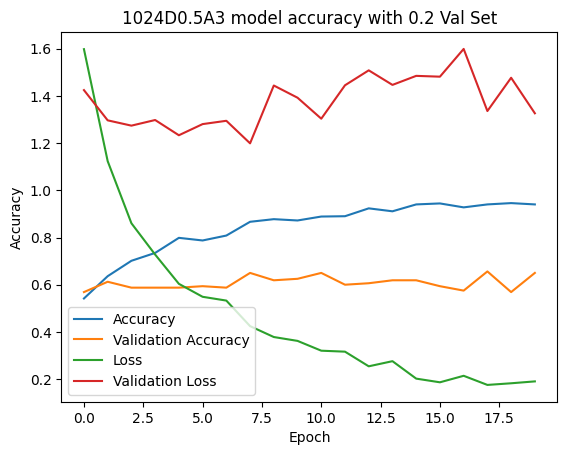

In [28]:
#Train the model
#MODEL_FILE = 'Default.model'

print("Model has started training")
history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_generator,
    validation_steps=VALIDATION_STEPS,
    callbacks=CALLBACKS,
    verbose=1)


#model.save(MODEL_FILE)

import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("1024D0.5A3 model accuracy with 0.2 Val Set")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","Loss","Validation Loss"]) #Is this loss?
plt.show()

In [29]:
history.history

{'loss': [1.5982840061187744,
  1.1236236095428467,
  0.8604562282562256,
  0.7277330756187439,
  0.6037304997444153,
  0.5487692952156067,
  0.5327004194259644,
  0.4244335889816284,
  0.378254234790802,
  0.3618912994861603,
  0.32035407423973083,
  0.3162233531475067,
  0.2541702687740326,
  0.27592068910598755,
  0.20198561251163483,
  0.18637536466121674,
  0.2139776647090912,
  0.1752810776233673,
  0.18224860727787018,
  0.1902620494365692],
 'accuracy': [0.5416666865348816,
  0.6361111402511597,
  0.7013888955116272,
  0.7347221970558167,
  0.7986111044883728,
  0.7875000238418579,
  0.8083333373069763,
  0.8666666746139526,
  0.8777777552604675,
  0.8722222447395325,
  0.8888888955116272,
  0.8902778029441833,
  0.9236111044883728,
  0.9111111164093018,
  0.9402777552604675,
  0.9444444179534912,
  0.9277777671813965,
  0.9402777552604675,
  0.9458333253860474,
  0.9402777552604675],
 'val_loss': [1.4247552156448364,
  1.2965996265411377,
  1.2741186618804932,
  1.297992706298

#Part 5: Fine Tuning the model

At this point, the top layers are well trained and we can start fine-tuning convolutional layers from VGG16. We will freeze the bottom (first) few layers and train the remaining top layers.

In [30]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
# for i, layer in enumerate(base_model.layers):
#    print(i, layer.name)


# we chose to train the top 2 convolutional blocks, i.e. we will freeze
# the first 11 layers and unfreeze the rest:
for layer in model.layers[:11]:
   layer.trainable = False
for layer in model.layers[11:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy',metrics = ['accuracy'])

# Save the best model.
checkpointF = ModelCheckpoint('best_1024_model.hdf5', monitor='val_loss', save_best_only=True, period=1)

# stop training sooner if it's overfitting # may need to increase regularization
earlyF = EarlyStopping(monitor='val_loss', min_delta=0, patience=1, verbose=1, mode='auto')

CALLBACKSF=[checkpointF,earlyF]

# we train our model again (this time fine-tuning the top 2 convolutional blocks
# alongside the top Dense layers, for only a few epochs
history_fine = model.fit(train_generator,
                         epochs=EPOCHS,
                         initial_epoch =  history.epoch[-1],
                         validation_data=validation_generator,
                         validation_steps=VALIDATION_STEPS,
                         callbacks=CALLBACKSF)

# Naive test accuracy over entire test set: probably very low
#print('Out of Sample Accuracy: ', model.evaluate(naive_test_generator, verbose=True))

# To be fair, if I showed you these images, you wouldn't be able to tell what's
# in them either

Epoch 20/32
23/23 [==============================] - 13s 369ms/step - loss: nan - accuracy: 0.1583 - val_loss: nan - val_accuracy: 0.0938
Epoch 20: early stopping


In [ ]:
print('Out of Sample Accuracy: ', model.evaluate(naive_test_generator, verbose=True))

# Part 6: Will do later

<Figure size 720x720 with 0 Axes>

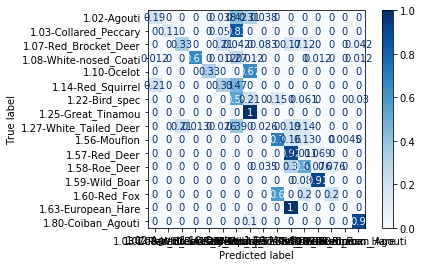

In [ ]:
#confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm=confusion_matrix(confusionTrue, confusionPred, labels=labels,normalize='true')
plt.figure(figsize=(10,10)) #Yeah, that's supposed to make it big. RIP

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp = disp.plot(cmap=plt.cm.Blues)

plt.show()

# Apparently everything is a Bird now.

In [ ]:
# Comletely out of sample test for the lulz
img_path = 'drive/My Drive/Colab Notebooks/ML Final Project/IsThisADeer.png'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)

j = np.argmax(preds)
print("it's a", labels[j]) # Usually Bird for 16 species and Deer for 10


it's a 1.57-Red_Deer
